# Settings, Directory Specs, and Imports

In [1]:

# 0 = no streamlit
# 1 = test user inputs
# 2 = run in streamlit
streamlit_status = 0
#file_name_pickle_read = 'model_2020_06_06_1105.pickle'
do_plots = 1

dir_read = '/Users/rachellehorwitz/Documents/ViTalErt/data/filtered05/'
#dir_read = '/Users/rachellehorwitz/Documents/VTAlert/over18_eicu/'

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import streamlit as st
import pickle
from datetime import datetime
import pyprojroot
from pandas_profiling import ProfileReport

pd.set_option('display.max_columns', None)

matplotlib.rcParams.update({'font.size': 33})





# eICU Data Wrangling

In [2]:
# Read files from csv
patient = pd.read_csv(dir_read + 'patient.csv')
admissiondx = pd.read_csv(dir_read + 'admissiondx.csv')
diagnosis = pd.read_csv(dir_read + 'diagnosis.csv')
ptusid_pos = pd.read_csv(dir_read + 'pos_ptunitstayid.csv')
hr = pd.read_csv(dir_read + 'vitalPeriodic_heartrate_first24.csv')
hr = hr.set_index('patientunitstayid')

print('There are ' + str(patient.shape[0]) + ' patientunitstayids in "patient.csv" but only ' \
      + str(hr.shape[0]) + ' patientunitstayids in the hr csv file')
print('Cleaning that up for patient, admissiondx, diagnosis, and ptusid_pos.')
patient = patient[patient['patientunitstayid'].isin(list(hr.index))]
admissiondx = admissiondx[admissiondx['patientunitstayid'].isin(list(hr.index))]
diagnosis = diagnosis[diagnosis['patientunitstayid'].isin(list(hr.index))]
ptusid_pos = ptusid_pos[ptusid_pos['patientunitstayid'].isin(list(hr.index))]

hr = hr.reset_index()

There are 161543 patientunitstayids in "patient.csv" but only 158784 patientunitstayids in the hr csv file
Cleaning that up for patient, admissiondx, diagnosis, and ptusid_pos.


In [3]:


# Create dataframe of patientunitstayids in negative class
tmp = patient[~patient['patientunitstayid'].isin(ptusid_pos['patientunitstayid'])]
ptusid_neg = tmp[['patientunitstayid']]

# Create labels
ptusid_neg = ptusid_neg.assign(label=0)
ptusid_pos = ptusid_pos.assign(label=1)

# Add labels to "patient" dataframe and move 'label' column to left
ptusid_w_label = pd.concat([ptusid_pos, ptusid_neg])
ptusid_w_label.shape[0]
ptusid_w_label = ptusid_w_label.set_index('patientunitstayid')
patient = patient.set_index('patientunitstayid')
patient = patient.join(ptusid_w_label)

# Move 'label' column to left
cols = list(patient.columns)
cols = [cols[-1]] + cols[:-1]
patient = patient[cols]

# Add BMI column to patient
patient = patient.assign(bmi=lambda x: x.admissionweight/((x.admissionheight/100)**2))

# Remove patients who weigh less than 40 kg or more than 400 kg
patient = patient[(patient['admissionweight'] > 40) & \
                   (patient['admissionweight'] < 400)]

# Remove patients who are shorter than 100 cm (3.2 ft) or taller than 230 cm (~7.5 ft)
patient = patient[(patient['admissionheight'] > 100 ) & (patient['admissionheight'] < 230)]

# Remove patients with BMI > 150
patient = patient[patient['bmi'] < 150]





In [4]:
hr_pos = hr[hr['patientunitstayid'].isin(list(ptusid_pos['patientunitstayid']))]
hr_neg = hr[hr['patientunitstayid'].isin(list(ptusid_neg['patientunitstayid']))]

In [5]:
# Dummy variables for gender, ethnicity, unitstaytype
patient = pd.concat([patient, pd.get_dummies(patient['gender'], prefix='gender')], axis=1)
patient = pd.concat([patient, pd.get_dummies(patient['ethnicity'], prefix='ethnicity')], axis=1)
patient = pd.concat([patient, pd.get_dummies(patient['unitstaytype'], prefix='unitstaytype')], axis=1)

nstds = 5
print(str(169+nstds*patient['admissionheight'].std()))
print(str(169-nstds*patient['admissionheight'].std()))

patient_pos = patient[patient['label']==1]
patient_neg = patient[patient['label']==0]
patient[patient['label']==1].shape[0]


# Drop unneeded columns of patient
patient = patient.drop(columns=['hospitalid', 'wardid', 'dischargeweight', 'unitdischargetime24', \
                                'unitdischargeoffset', 'unitdischargelocation', 'hospitaldischargeyear',\
                               'hospitaldischargetime24', 'hospitaldischargelocation'])
apacheaddx_all = patient['apacheadmissiondx'].value_counts()



223.2660110885446
114.73398891145541


# AdmissionDX

In [6]:
admissiondx = admissiondx[['patientunitstayid', 'diagnosisstring']]
admissiondx.head()

,patientunitstayid,diagnosisstring
0,141168,cardiovascular|chest pain / ASHD|coronary arte...
1,141168,cardiovascular|ventricular disorders|cardiomyo...
2,141168,pulmonary|disorders of the airways|COPD
3,141168,pulmonary|disorders of the airways|COPD
4,141168,cardiovascular|ventricular disorders|congestiv...


In [7]:
df = admissiondx.groupby(['patientunitstayid', 'diagnosisstring']).size().reset_index(name='Freq')
df = df.drop(columns='Freq')
df.head(30)

,patientunitstayid,diagnosisstring
0,141168,cardiovascular|arrhythmias|atrial fibrillation...
1,141168,cardiovascular|chest pain / ASHD|coronary arte...
2,141168,cardiovascular|ventricular disorders|cardiomyo...
3,141168,cardiovascular|ventricular disorders|congestiv...
4,141168,pulmonary|disorders of the airways|COPD
5,141168,renal|disorder of kidney|chronic kidney disease
6,141203,cardiovascular|chest pain / ASHD|coronary arte...
7,141203,endocrine|glucose metabolism|diabetes mellitus
8,141203,hematology|coagulation disorders|coagulopathy
9,141203,infectious diseases|GI infections|diarrhea due...


In [8]:
foo = df['diagnosisstring'].str.split(pat = '|', expand=True)
foo = foo.rename(columns={0: 'Lev1', 1: 'Lev2', 2: 'Lev3'})
foo.head()

,Lev1,Lev2,Lev3,3,4,5
0,cardiovascular,arrhythmias,atrial fibrillation,with hemodynamic compromise,None,None
1,cardiovascular,chest pain / ASHD,coronary artery disease,known,None,None
2,cardiovascular,ventricular disorders,cardiomyopathy,None,None,None
3,cardiovascular,ventricular disorders,congestive heart failure,None,None,None
4,pulmonary,disorders of the airways,COPD,None,None,None


In [9]:
admitdx = df.join(foo[['Lev1']])
admitdx.head(10)

,patientunitstayid,diagnosisstring,Lev1
0,141168,cardiovascular|arrhythmias|atrial fibrillation...,cardiovascular
1,141168,cardiovascular|chest pain / ASHD|coronary arte...,cardiovascular
2,141168,cardiovascular|ventricular disorders|cardiomyo...,cardiovascular
3,141168,cardiovascular|ventricular disorders|congestiv...,cardiovascular
4,141168,pulmonary|disorders of the airways|COPD,pulmonary
5,141168,renal|disorder of kidney|chronic kidney disease,renal
6,141203,cardiovascular|chest pain / ASHD|coronary arte...,cardiovascular
7,141203,endocrine|glucose metabolism|diabetes mellitus,endocrine
8,141203,hematology|coagulation disorders|coagulopathy,hematology
9,141203,infectious diseases|GI infections|diarrhea due...,infectious diseases


In [10]:
mystrings = foo['Lev1'].unique()
admitdx.columns

Index(['patientunitstayid', 'diagnosisstring', 'Lev1'], dtype='object')

In [11]:
addx = pd.get_dummies(admitdx['Lev1'], prefix='Lev1')
addx2 = admitdx.groupby('patientunitstayid')['Lev1'].unique()
#addx3 = 
#drugs3_1 = drugs3.groupby('SEQN').agg({'year':'first', 'taken_rx_med_30d_1.0’:’sum’}).reset_index()

<IPython.core.display.Javascript object>


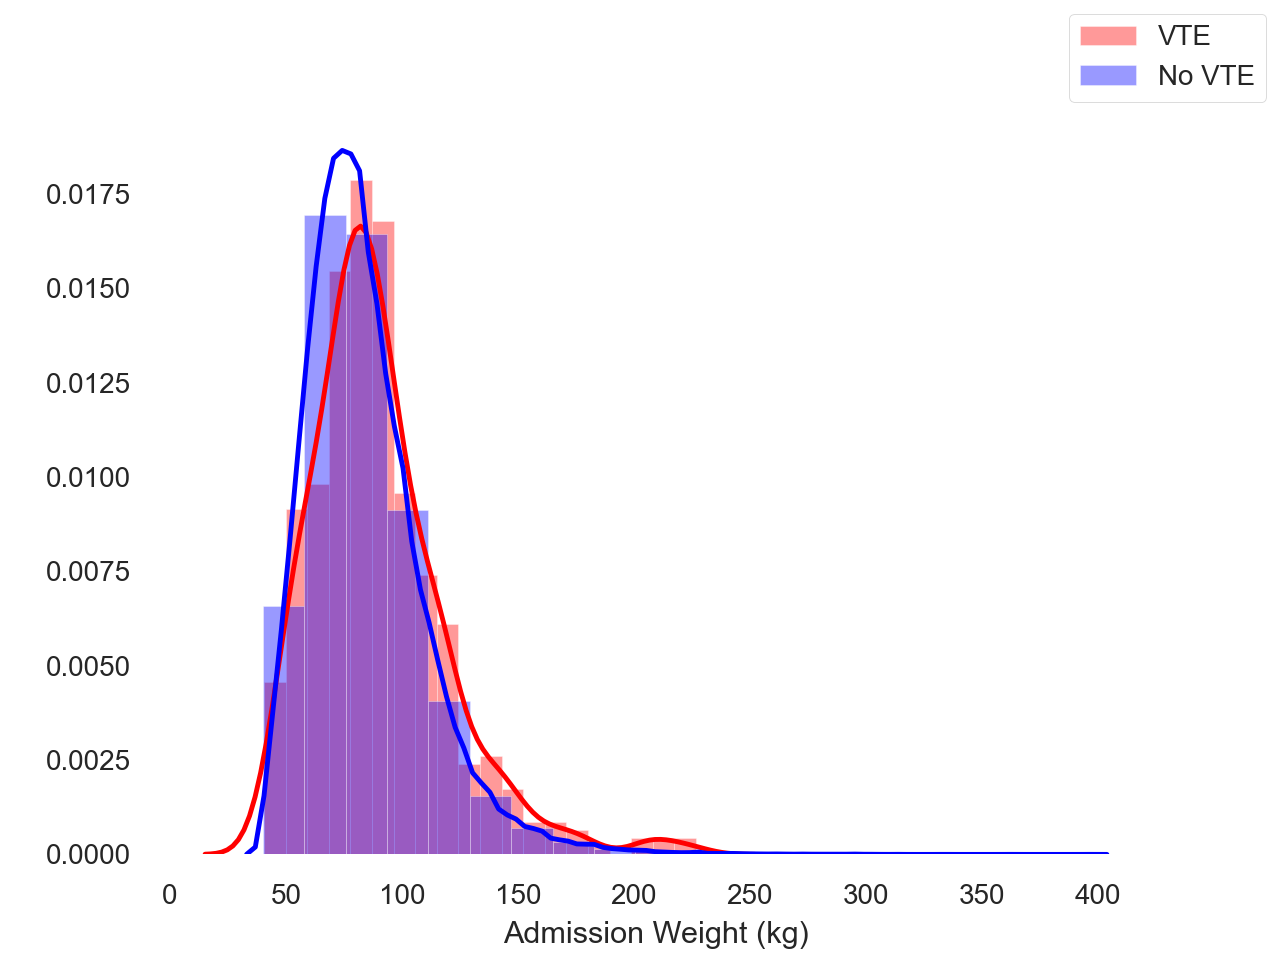

<IPython.core.display.Javascript object>


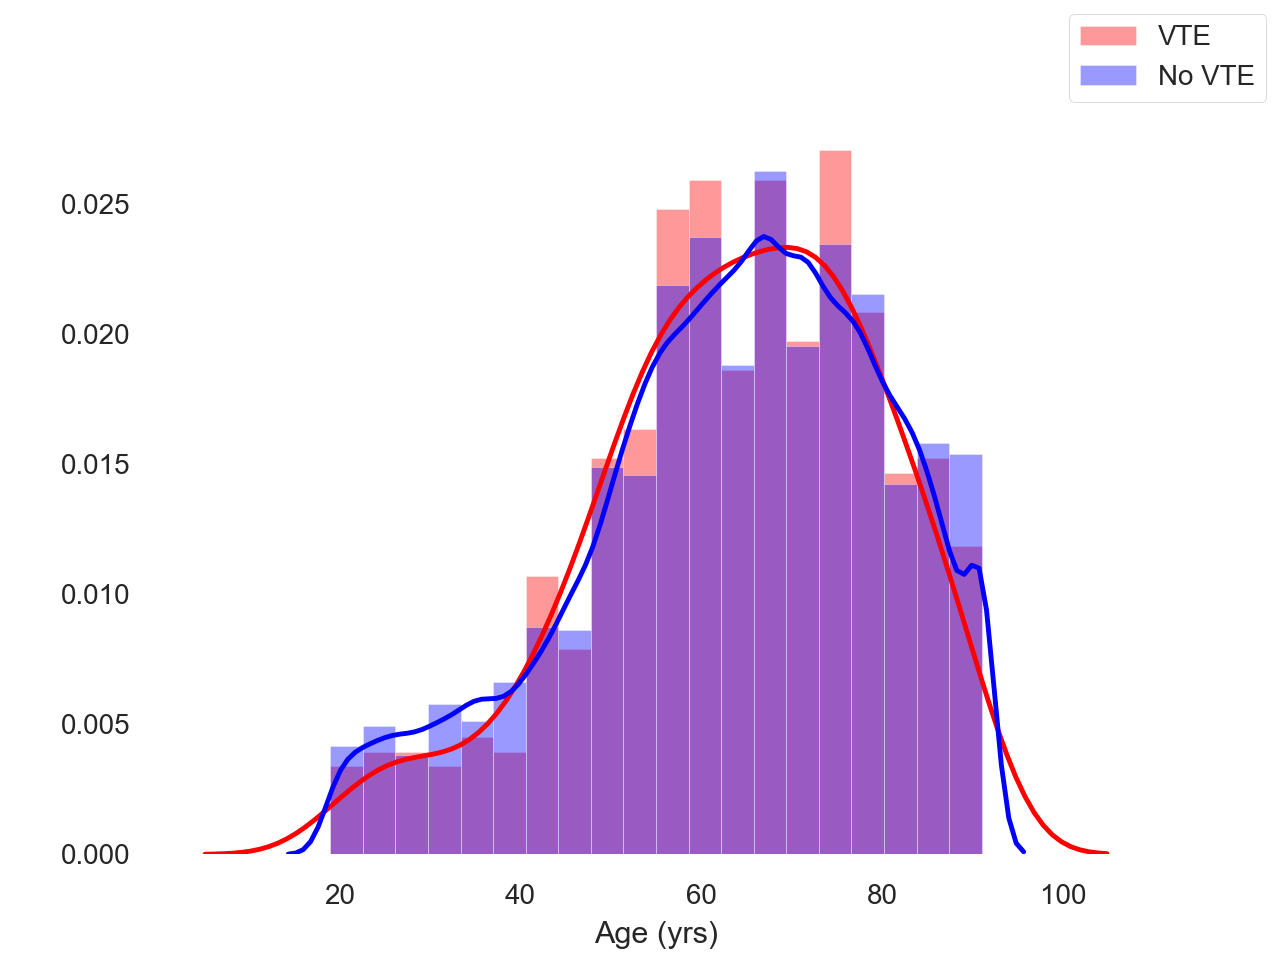

<IPython.core.display.Javascript object>


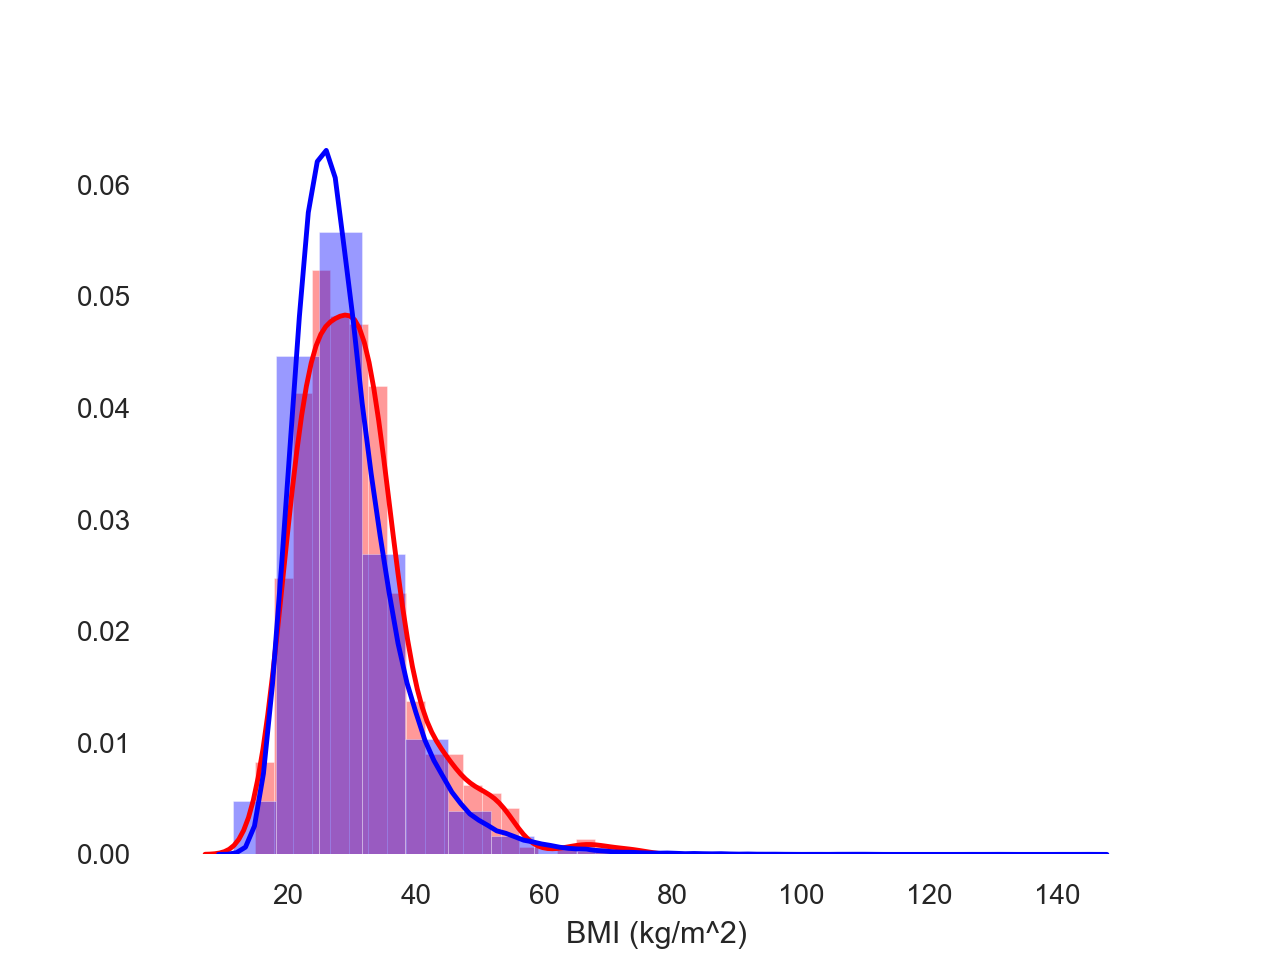

<IPython.core.display.Javascript object>


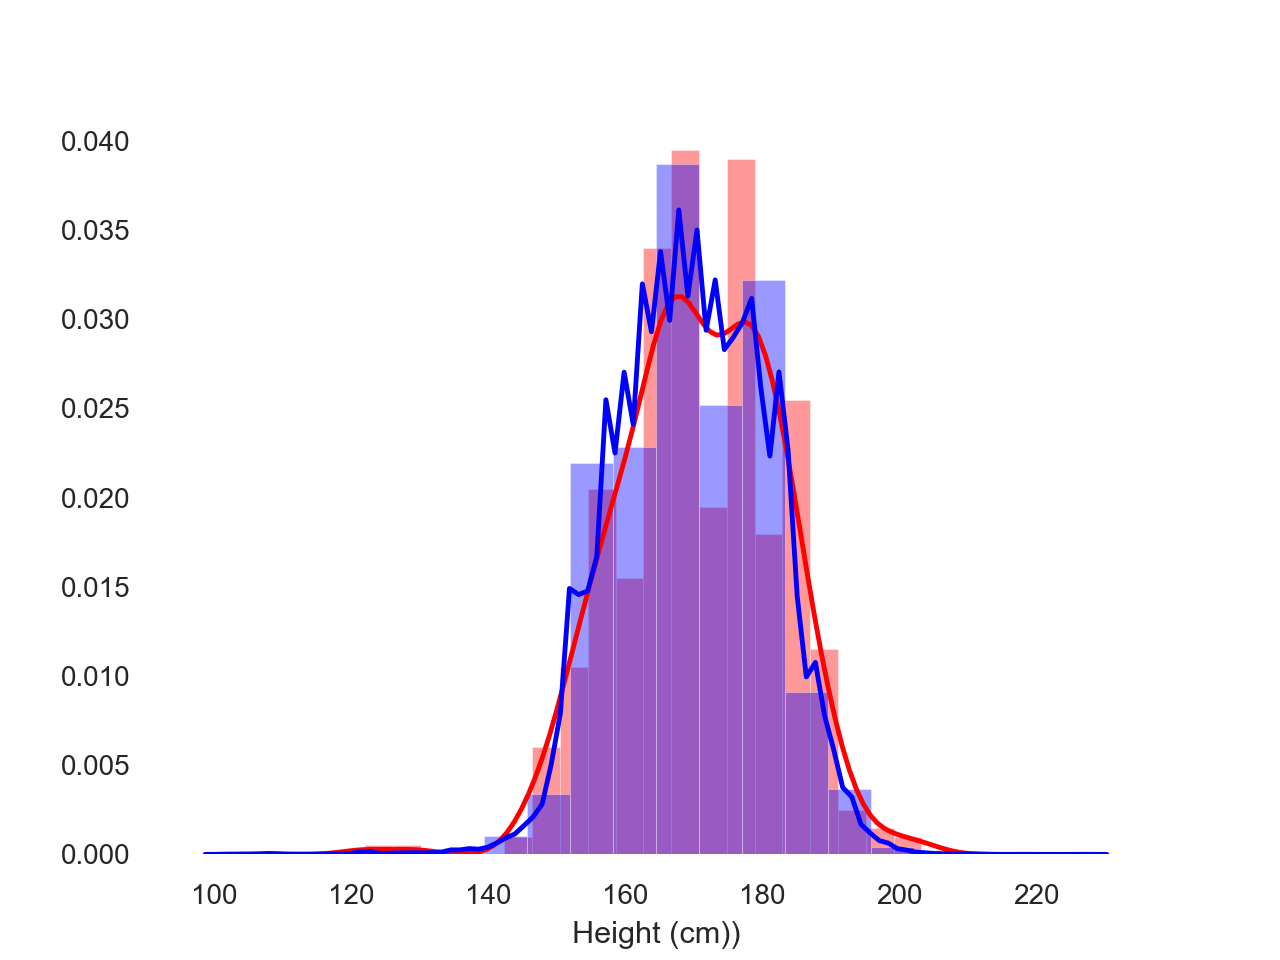

<IPython.core.display.Javascript object>


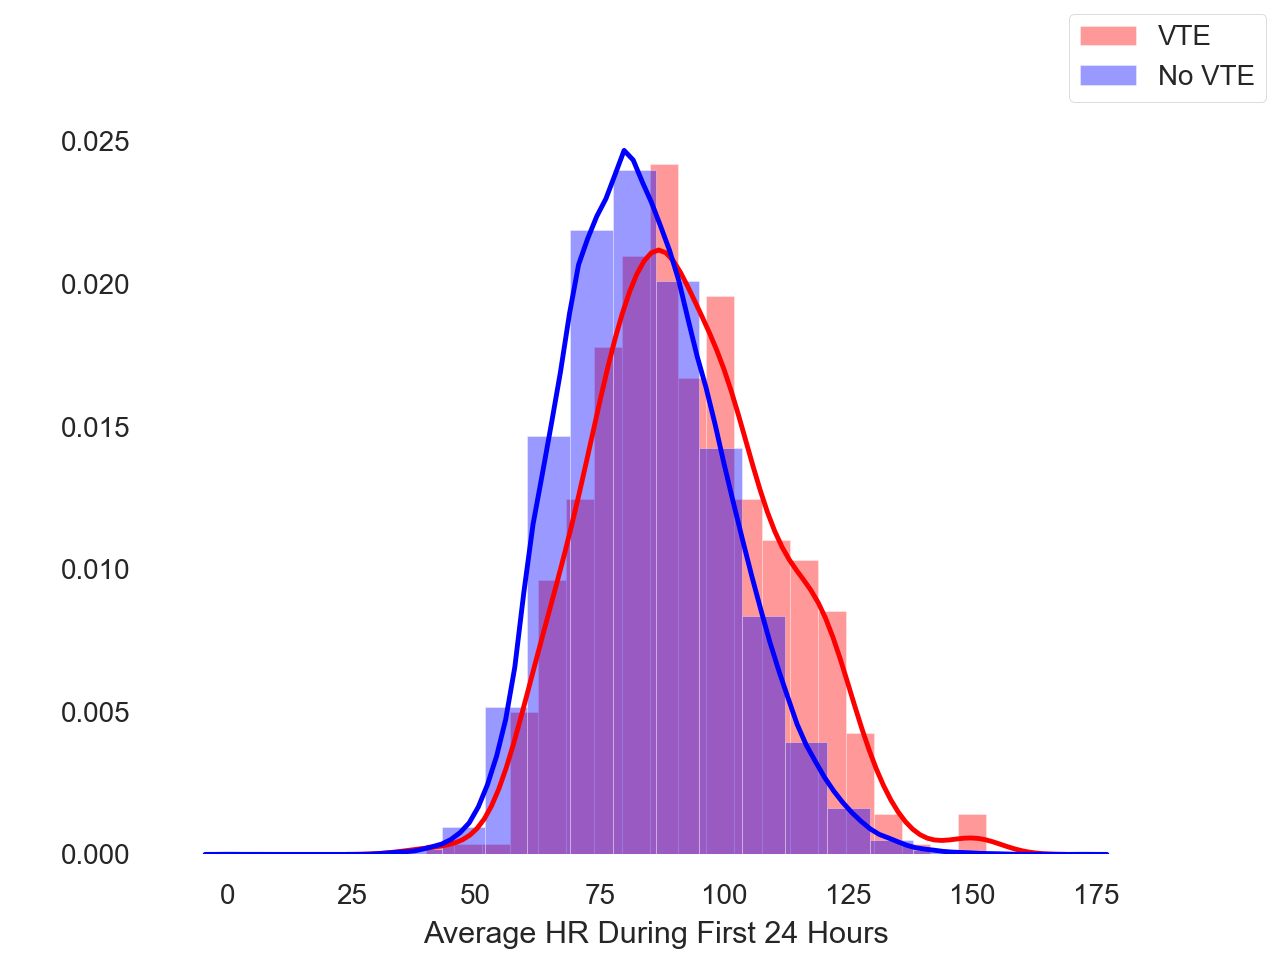

In [12]:
%matplotlib notebook
import seaborn as sns

fig = plt.figure()
VTE = sns.distplot(patient_pos['admissionweight'], color='red', bins=20)
noVTE = sns.distplot(patient_neg['admissionweight'], color='blue', bins=20)
plt.xlabel('Admission Weight (kg)')
fig.legend(labels=['VTE', 'No VTE'])

fig = plt.figure()
sns.distplot(patient_pos['age'], color='red', bins=20)
sns.distplot(patient_neg['age'], color='blue', bins=20)
fig.legend(labels=['VTE', 'No VTE'])
plt.xlabel('Age (yrs)')

fig = plt.figure()
sns.distplot(patient_pos['bmi'], color='red', bins=20)
sns.distplot(patient_neg['bmi'], color='blue', bins=20)
plt.xlabel('BMI (kg/m^2)')

fig = plt.figure()
sns.distplot(patient_pos['admissionheight'], color='red', bins=20)
sns.distplot(patient_neg['admissionheight'], color='blue', bins=20)
plt.xlabel('Height (cm))')

fig = plt.figure()
sns.distplot(hr_pos['heartrate'], color='red', bins=20)
sns.distplot(hr_neg['heartrate'], color='blue', bins=20)
plt.xlabel('Average HR During First 24 Hours')
fig.legend(labels=['VTE', 'No VTE'])


# ApachePredVar

In [ ]:
u_ptunitstayid = list(patient.index)
apachepredvar = pd.read_csv('/Users/rachellehorwitz/Documents/ViTalErt/data/over18_eicu/apachePredVar.csv')
apachepredvar = apachepredvar[apachepredvar['patientunitstayid'].isin(u_ptunitstayid)]

# Drop columns based on apachepredvar_allcols.html
apachepredvar = apachepredvar.drop(columns=['apachepredvarid', 'sicuday', 'saps3day1', 'saps3yesterday', 'saps3today', 'gender', \
                                    'teachtype', 'region', 'amilocation', 'bedcount', 'admitsource', 'graftcount', 'age', \
                                   'meds', 'diedinhospital', 'electivesurgery', 'readmit', 'managementsystem', 'var03hspxlos', \
                                   'ejectfx', 'day1meds', 'day1verbal', 'day1motor', 'day1eyes',  'day1pao2', 'day1fio2', \
                                           'ventday1', 'creatinine', 'dischargelocation', 'pao2', 'fio2']) # pao2 and fio2 are <0 too frequently
apachepredvar = apachepredvar.drop(columns=['admitdiagnosis'])
apachepredvar = apachepredvar[apachepredvar['verbal']!=-1] # Get rid of missing data
apachepredvar.set_index('patientunitstayid')

In [ ]:
removed_cols = ['apachepredvarid', 'sicuday', 'saps3day1', 'saps3yesterday', 'saps3today', 'gender', \
                                    'teachtype', 'region', 'amilocation', 'bedcount', 'admitsource', 'graftcount', 'age', \
                                   'meds', 'diedinhospital', 'electivesurgery', 'readmit', 'managementsystem', 'var03hspxlos', \
                                   'ejectfx', 'day1meds', 'day1verbal', 'day1motor', 'day1eyes',  'day1pao2', 'day1fio2', \
                                           'ventday1', 'creatinine', 'dischargelocation', 'pao2', 'fio2', 'admitdiagnosis']

In [ ]:
len(removed_cols)

# Define X and y

In [ ]:
Xy = patient[['label', 'age', 'admissionweight', 'admissionheight', 'bmi', 'gender_Female',
       'ethnicity_African American', 'ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic',
       'ethnicity_Native American', 'ethnicity_Other/Unknown',
       'unitstaytype_admit', 'unitstaytype_readmit', 'unitstaytype_transfer']]

In [ ]:
Xy.shape

In [ ]:
apachepredvar.shape

In [ ]:
Xy2 = Xy.merge(apachepredvar, how='right', left_on='patientunitstayid', right_on='patientunitstayid')

In [ ]:
Xy3 = Xy2.merge(hr, how='inner', left_on='patientunitstayid', right_on='patientunitstayid')

In [ ]:
Xy3.head()

In [ ]:
Xy3.shape[0]

In [ ]:
Xy3[Xy3['label']==0].shape[0]

In [ ]:
Xy3[Xy3['label']==1].shape[0]

In [ ]:
Xy3.columns.shape

In [ ]:
Xy3.columns

In [ ]:
profile = ProfileReport(Xy3, title='Pandas Profiling Report')

In [ ]:
#profile.to_file("X_2020_06_11.html")

In [ ]:
#Xy3.to_csv('Xy_2020_06_11_1916.csv', index=False)